[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/experimental/algos-and-libraries/bertopic/05_topic_model_detail.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/experimental/algos-and-libraries/bertopic/05_topic_model_detail.ipynb)

# BERTopic Modeling Breakdown

In this notebook we will work through the same steps BERTopic performs but step-by-step.

## Data Prep

First we need the text data.

In [1]:
from datasets import load_dataset

data = load_dataset(
    'jamescalam/reddit-topics', split='train',
    revision='c14d532'  # this specifies current version of dataset
)
data

Using custom data configuration jamescalam--reddit-topics-36b2068b7cd7acf8
Reusing dataset json (/Users/jamesbriggs/.cache/huggingface/datasets/json/jamescalam--reddit-topics-36b2068b7cd7acf8/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


Dataset({
    features: ['sub', 'title', 'selftext', 'upvote_ratio', 'id', 'created_utc'],
    num_rows: 3791
})

In [2]:
data = data.filter(lambda x: True if len(x['selftext']) > 30 else 0)
data

Loading cached processed dataset at /Users/jamesbriggs/.cache/huggingface/datasets/json/jamescalam--reddit-topics-36b2068b7cd7acf8/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b/cache-50063e96c8952ccf.arrow


Dataset({
    features: ['sub', 'title', 'selftext', 'upvote_ratio', 'id', 'created_utc'],
    num_rows: 3118
})

In [3]:
data = data.shuffle()

In [4]:
n = len(data)  # number of records we will use

## 1. Embedding

The first step is embedding with a sentence transformer model. We're doing this for relatively generic data and we will not be fine-tuning a model so we will use one of the better off-the-shelf sentence transformers from the `sentence-transformers` library.

In [5]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

Then we create embeddings, we do this in batches.

In [6]:
import numpy as np
from tqdm.auto import tqdm

batch_size = 16

embeds = np.zeros((n, model.get_sentence_embedding_dimension()))

for i in tqdm(range(0, n, batch_size)):
    i_end = min(i+batch_size, n)
    batch = data['selftext'][i:i_end]
    batch_embed = model.encode(batch)
    embeds[i:i_end,:] = batch_embed

100%|██████████| 195/195 [08:43<00:00,  2.68s/it]


Now we can move onto dim reduction and clustering...

## UMAP Dimensionality Reduction

We'll start by testing with several UMAP parameters and visualizing the results.

In [7]:
set(data['sub'][:n])

{'LanguageTechnology', 'Python', 'investing', 'pytorch'}

In [8]:
colors = data['sub'][:n]
c_map = {
    'LanguageTechnology': '#FAFF00',
    'Python': '#1C17FF',
    'investing': '#738FAB',
    'pytorch': '#8CF1FF'
}
colors = [c_map[x] for x in colors]
colors[:3]

['#738FAB', '#8CF1FF', '#738FAB']

  0%|          | 0/9 [00:00<?, ?it/s]OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/homebrew/anaconda3/envs/stoic/lib/python3.8/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
100%|██████████| 9/9 [01:04<00:00,  7.20s/it]


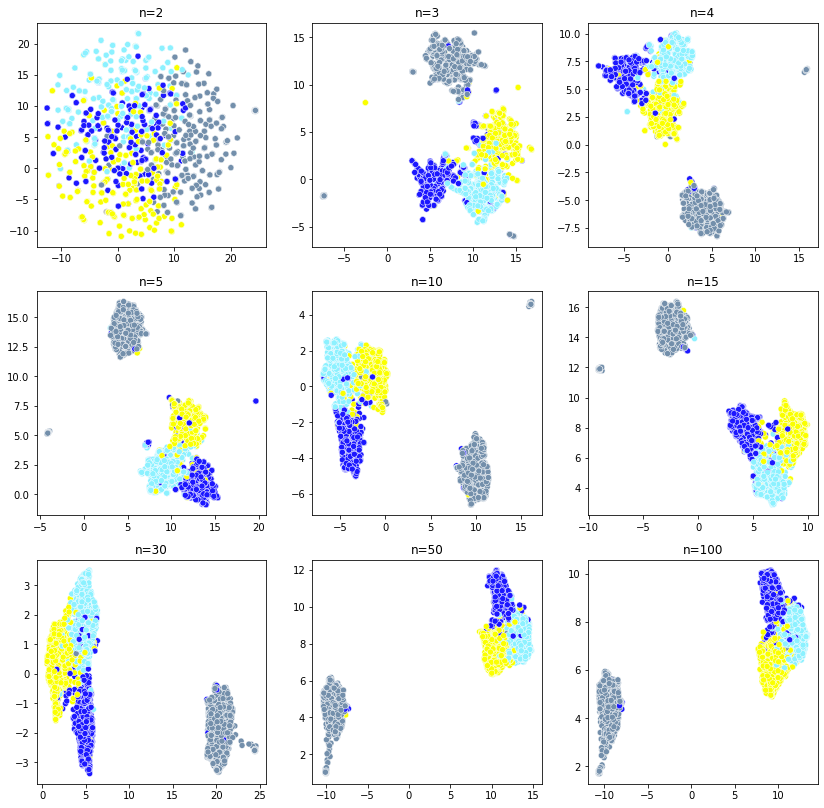

In [9]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(3, 3, figsize=(14, 14))
nns = [2, 3, 4, 5, 10, 15, 30, 50, 100]
i, j = 0, 0
for n_neighbors in tqdm(nns):
    fit = umap.UMAP(n_neighbors=n_neighbors)
    u = fit.fit_transform(embeds)
    sns.scatterplot(x=u[:,0], y=u[:,1], c=colors, ax=ax[j, i])
    ax[j, i].set_title(f'n={n_neighbors}')
    if i < 2: i += 1
    else: i = 0; j += 1

Using labels to train the model, a `n_neighbors` of `3` to `5` seem to perform best, we can increase the number of dimensions up to 3D and test a few more parameters, one of the strongest splits seems to be using `n_neighbors=3` and `min_dist=0.05`.

In [59]:
import plotly.express as px

palette = ['#1c17ff', '#faff00', '#8cf1ff', '#738FAB', '#030080', '#738fab']

fit = umap.UMAP(n_neighbors=4, n_components=3, min_dist=0.05)
u = fit.fit_transform(embeds)

fig = px.scatter_3d(
    x=u[:,0], y=u[:,1], z=u[:,2],
    color=data['sub'][:n],
    custom_data=[data['sub'][:n], data['title'][:n]],
    color_discrete_sequence=palette
)
fig.update_traces(
    hovertemplate="<br>".join([
        "sub: %{customdata[1]}",
        "title: %{customdata[0]}"
    ])
)

In [60]:
fig.write_html("umap-topics-3d-color.html", include_plotlyjs="cdn", full_html=False)

In [61]:
fig = px.scatter_3d(
    x=u[:,0], y=u[:,1], z=u[:,2],
    custom_data=[data['sub'][:n], data['title'][:n]],
    color_discrete_sequence=[palette[0]]
)
fig.update_traces(
    hovertemplate="<br>".join([
        "sub: %{customdata[1]}",
        "title: %{customdata[0]}"
    ])
)

In [62]:
fig.write_html("umap-topics-3d-nocolor.html", include_plotlyjs="cdn", full_html=False)

## Clustering with HDBSCAN

We can only view our clusters using existing labels, but if we want to predict topics for new inputs we need to be able to cluster automatically.

To do this we use HDBSCAN like so:

In [63]:
import hdbscan

clusterer = hdbscan.HDBSCAN()
clusterer.fit(u)

HDBSCAN()

<AxesSubplot:ylabel='$\\lambda$ value'>

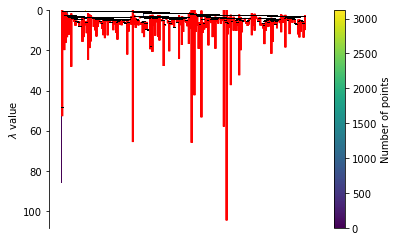

In [64]:
clusterer.condensed_tree_.plot(select_clusters=True)

Using the condensed tree plot we can see we have what seem to be too many clusters, we can increase the `min_cluster_size` to merge the smaller clusters.

<AxesSubplot:ylabel='$\\lambda$ value'>

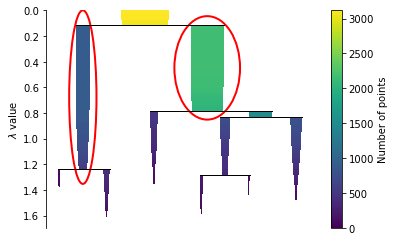

In [65]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=80)
clusterer.fit(u)

clusterer.condensed_tree_.plot(select_clusters=True)

Not quite there, we can try and reduce the `min_cluster_size` to pull in the three clusters below the green block.

<AxesSubplot:ylabel='$\\lambda$ value'>

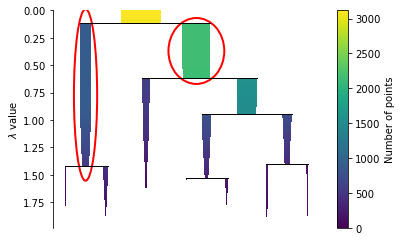

In [66]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=60)
clusterer.fit(u)

clusterer.condensed_tree_.plot(select_clusters=True)

Unfortunately this still pulls in the green block and even allows *too small* clusters (as on the left). Another alternative is maintaining the `min_cluster_size=80` as this does not seem to be the problem here. Instead, we add `min_samples=40` which tells HDBSCAN to allow for more sparse core points (allowing sparser clusters to be pulled in).

<AxesSubplot:ylabel='$\\lambda$ value'>

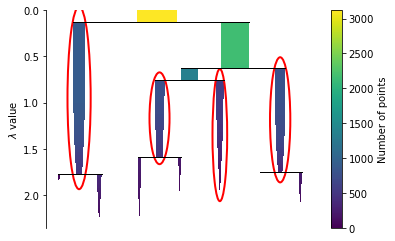

In [68]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=80, min_samples=40)
clusterer.fit(u)

clusterer.condensed_tree_.plot(select_clusters=True)

Perfect! We now have what look to be four very promising clusters, let us take a look.

In [69]:
colors = [str(x) for x in clusterer.labels_]

fig = px.scatter_3d(
    x=u[:,0], y=u[:,1], z=u[:,2],
    color=colors,
    custom_data=[data['sub'][:n], data['title'][:n]],
    color_discrete_sequence=palette
)
fig.update_traces(
    hovertemplate="<br>".join([
        "sub: %{customdata[1]}",
        "title: %{customdata[0]}"
    ])
)

In [70]:
fig.write_html("hdbscan-topics-3d.html", include_plotlyjs="cdn", full_html=False)

We have a few outliers and some mislabeled samples, but both of these are to be expected. Overall, this clustering looks excellent.

## Finding Topics with c-TF-IDF

We now have our clusters and can move onto extracting their topics. We do this using a modified version of TF-IDF called **c**lass-TF-IDF (c-TF-IDF).

We need to seperate our `selftext` items into their classes as defined by HDBSCAN.

In [71]:
classes = {}
for label in set(clusterer.labels_):
    classes[label] = {
        'vocab': set(),
        'tokens': [],
        'tfidf_array': None
    }
classes

{0: {'vocab': set(), 'tokens': [], 'tfidf_array': None},
 1: {'vocab': set(), 'tokens': [], 'tfidf_array': None},
 2: {'vocab': set(), 'tokens': [], 'tfidf_array': None},
 3: {'vocab': set(), 'tokens': [], 'tfidf_array': None},
 -1: {'vocab': set(), 'tokens': [], 'tfidf_array': None}}

Add HDBSCAN classes to dataset

In [72]:
data = data.add_column('class', clusterer.labels_)
data

Flattening the indices: 100%|██████████| 4/4 [00:00<00:00, 62.89ba/s]


Dataset({
    features: ['sub', 'title', 'selftext', 'upvote_ratio', 'id', 'created_utc', 'class'],
    num_rows: 3118
})

We need to get a list of all terms, we will tokenize and then drop common English stopwords + punctuation.

In [73]:
import re

# first lowercase and remove punctuation
alpha = re.compile(r'[^a-zA-Z ]+')
data = data.map(lambda x: {
    'tokens': alpha.sub('', x['selftext']).lower()
})

100%|██████████| 3118/3118 [00:00<00:00, 11649.63ex/s]


In [74]:
data[0]

{'sub': 'investing',
 'title': 'Daily General Discussion and Advice Thread - March 03, 2022',
 'selftext': 'Have a general question?  Want to offer some commentary on markets?  Maybe you would just like to throw out a neat fact that doesn\'t warrant a self post?  Feel free to post here! \n\nIf your question is "I have $10,000, what do I do?" or other "advice for my personal situation" questions, you should include relevant information, such as the following:\n\n* How old are you? What country do you live in?  \n* Are you employed/making income? How much?  \n* What are your objectives with this money? (Buy a house? Retirement savings?)  \n* What is your time horizon? Do you need this money next month? Next 20yrs?  \n* What is your risk tolerance? (Do you mind risking it at blackjack or do you need to know its 100% safe?)  \n* What are you current holdings? (Do you already have exposure to specific funds and sectors? Any other assets?)  \n* Any big debts (include interest rate) or expens

In [75]:
import nltk

data = data.map(lambda x: {
    'tokens': nltk.tokenize.wordpunct_tokenize(x['tokens'])
})

100%|██████████| 3118/3118 [00:00<00:00, 7893.81ex/s]


In [76]:
data[0]

{'sub': 'investing',
 'title': 'Daily General Discussion and Advice Thread - March 03, 2022',
 'selftext': 'Have a general question?  Want to offer some commentary on markets?  Maybe you would just like to throw out a neat fact that doesn\'t warrant a self post?  Feel free to post here! \n\nIf your question is "I have $10,000, what do I do?" or other "advice for my personal situation" questions, you should include relevant information, such as the following:\n\n* How old are you? What country do you live in?  \n* Are you employed/making income? How much?  \n* What are your objectives with this money? (Buy a house? Retirement savings?)  \n* What is your time horizon? Do you need this money next month? Next 20yrs?  \n* What is your risk tolerance? (Do you mind risking it at blackjack or do you need to know its 100% safe?)  \n* What are you current holdings? (Do you already have exposure to specific funds and sectors? Any other assets?)  \n* Any big debts (include interest rate) or expens

Add tokenized sentences to the `classes` dictionary.

In [77]:
for row in data:
    classes[row['class']]['tokens'].extend(row['tokens'])

In [78]:
for c in classes.keys():
    stopwords = set(nltk.corpus.stopwords.words('english'))
    # stopwords from nltk are all lowercase (so are our tokens)
    classes[c]['tokens'] = [
        word for word in classes[c]['tokens'] if word not in stopwords
    ]
    print(f"{c}: {len(classes[c]['tokens'])}")

0: 73842
1: 46574
2: 52791
3: 30949
-1: 7429


Create the vocabs (both overall and class)

In [79]:
vocab = set()
for c in classes.keys():
    vocab = vocab.union(set(classes[c]['tokens']))
    classes[c]['vocab'] = set(classes[c]['tokens'])

Get word frequency per class (TF).

In [80]:
tf = np.zeros((len(classes.keys()), len(vocab)))

for c, _class in enumerate(classes.keys()):
    for t, term in enumerate(tqdm(vocab)):
        tf[c, t] = classes[_class]['tokens'].count(term)

100%|██████████| 31250/31250 [00:03<00:00, 8385.79it/s] 


In [81]:
tf

array([[  1.,   0.,   4., ...,   1., 177.,   1.],
       [  0.,   0.,  20., ...,   0.,  16.,   1.],
       [  0.,   1.,   4., ...,   0.,  51.,   5.],
       [  0.,   0.,   0., ...,   0.,  36.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

Now calculate IDF

In [82]:
idf = np.zeros((1, len(vocab)))

# calculate average number of words per class
A = tf.sum() / tf.shape[0]

for t, term in enumerate(tqdm(vocab)):
    # frequency of term t across all classes
    f_t = tf[:,t].sum()
    # calculate IDF
    idf_score = np.log(1 + (A / f_t))
    idf[0, t] = idf_score

100%|██████████| 31250/31250 [00:00<00:00, 215843.43it/s]


In [83]:
idf

array([[10.65296781, 10.65296781,  7.32140112, ..., 10.65296781,
         5.0247495 ,  8.70719943]])

In [84]:
tf_idf = tf*idf

In [85]:
tf_idf

array([[ 10.65296781,   0.        ,  29.28560448, ...,  10.65296781,
        889.38066222,   8.70719943],
       [  0.        ,   0.        , 146.42802238, ...,   0.        ,
         80.39599207,   8.70719943],
       [  0.        ,  10.65296781,  29.28560448, ...,   0.        ,
        256.26222471,  43.53599715],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        180.89098215,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

Get the top `n` most common words per class

In [86]:
n = 5

In [87]:
top_idx = np.argpartition(tf_idf, -n)[:, -n:]
top_idx

array([[31130,  7677, 15408, 24406, 24165],
       [ 1248, 15408,  4873, 17200, 27582],
       [29860, 10373, 17200,  2761,  1761],
       [21275, 21683, 15519,   802,  7088],
       [ 9974,  8792, 19143, 12105,  3664]])

In [88]:
vlist = list(vocab)

for c, _class in enumerate(classes.keys()):
    topn_idx = top_idx[c, :]
    topn_terms = [vlist[idx] for idx in topn_idx]
    print(topn_terms)

['like', 'im', 'would', 'stock', 'market']
['data', 'would', 'nlp', 'model', 'text']
['training', 'pytorch', 'model', 'gt', 'x']
['using', 'project', 'use', 'code', 'python']
['useful', 'include', 'consider', 'financial', 'relevant']


And there we have our topics in the top four rows, followed by our outliers in the final row which with the exception of *'financial'* are indeed very generic as we would expect.